In [2]:
import os
import monai as mn
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import random

In [3]:
def filter_slices_by_threshold(img_slice, concat_slice, threshold=0.01):
    brain_mask_img = img_slice > threshold
    brain_mask_concat = concat_slice > threshold
    brain_volume_img = np.sum(brain_mask_img)
    brain_volume_concat = np.sum(brain_mask_concat)
    return brain_volume_img, brain_volume_concat

def load_patient_data_only_3T(dataset_dir, max_patients=5):
    patient_data_dicts = {}
    patient_count = 0 
    
    for patient_id in sorted(os.listdir(dataset_dir)):
        if patient_count >= max_patients:
            break  
        
        patient_dir = os.path.join(dataset_dir, patient_id)
        if os.path.isdir(patient_dir):
            patient_slices = []
            images = {}
            
            for file_name in sorted(os.listdir(patient_dir)):
                if file_name.endswith('.nii.gz'):
                    file_path = os.path.join(patient_dir, file_name)
                    print(f"Loading file: {file_path}")  
                    
                    nii_image = nib.load(file_path)
                    image_data = nii_image.get_fdata()

                    if '_rician_noise' in file_name:
                        base_name = file_name.replace('_rician_noise', '').split('.')[0]
                        if base_name not in images:
                            images[base_name] = {}
                        images[base_name]['concat'] = image_data
                    else:
                        base_name = file_name.split('.')[0]
                        if base_name not in images:
                            images[base_name] = {}
                        images[base_name]['img'] = image_data

            for base_name, img_pair in images.items():
                if 'img' in img_pair and 'concat' in img_pair:
                    img_data = img_pair['img']
                    concat_data = img_pair['concat']

                    num_slices = img_data.shape[2]

                    for i in range(num_slices):
                        brain_volume_img, brain_volume_concat = filter_slices_by_threshold(
                            img_data[:, :, i], concat_data[:, :, i], threshold=0.01
                        )
                        if brain_volume_img > 100 and brain_volume_concat > 100:  
                            patient_slices.append({
                                'img': img_data[:, :, i][np.newaxis, :, :],  
                                'concat': concat_data[:, :, i][np.newaxis, :, :], 
                                'cls': 0 
                            })
            
            if patient_slices:
                patient_data_dicts[patient_id] = patient_slices
                patient_count += 1  
    
    return patient_data_dicts

In [5]:
def visualize_transformed_images(data_dict, transform, num_images=3, num_slices=3):
    sample_keys = random.sample(list(data_dict.keys()), num_images)
    
    for key in sample_keys:
        img_data = data_dict[key]
        total_slices = len(img_data)
        
        middle_index = total_slices // 2
        start_index = max(0, middle_index - num_slices // 2)
        end_index = min(total_slices, middle_index + num_slices // 2 + 1)
        
        selected_slices = img_data[start_index:end_index]
        
        for i, slice_data in enumerate(selected_slices):
            original_img = slice_data['img']
            original_concat = slice_data['concat']
            
            transformed = transform({"img": original_img, "concat": original_concat})
            
            transformed_img = transformed['img'].numpy()
            transformed_concat = transformed['concat'].numpy()
            
            original_img = np.squeeze(original_img)
            original_concat = np.squeeze(original_concat)
            transformed_img = np.squeeze(transformed_img)
            transformed_concat = np.squeeze(transformed_concat)
            
            fig, axes = plt.subplots(2, 2, figsize=(10, 10))
            
            axes[0, 0].imshow(original_img, cmap='gray')
            axes[0, 0].set_title(f'Original 3.0T Image - Slice {start_index + i}')
            
            axes[0, 1].imshow(original_concat, cmap='gray')
            axes[0, 1].set_title(f'Noisy 3.0T Image - Slice {start_index + i}')
            
            axes[1, 0].imshow(transformed_img, cmap='gray')
            axes[1, 0].set_title(f'Transformed 3.0T Image - Slice {start_index + i}')
            
            axes[1, 1].imshow(transformed_concat, cmap='gray')
            axes[1, 1].set_title(f'Transformed Noisy 3.0T Image - Slice {start_index + i}')
            
            plt.show()

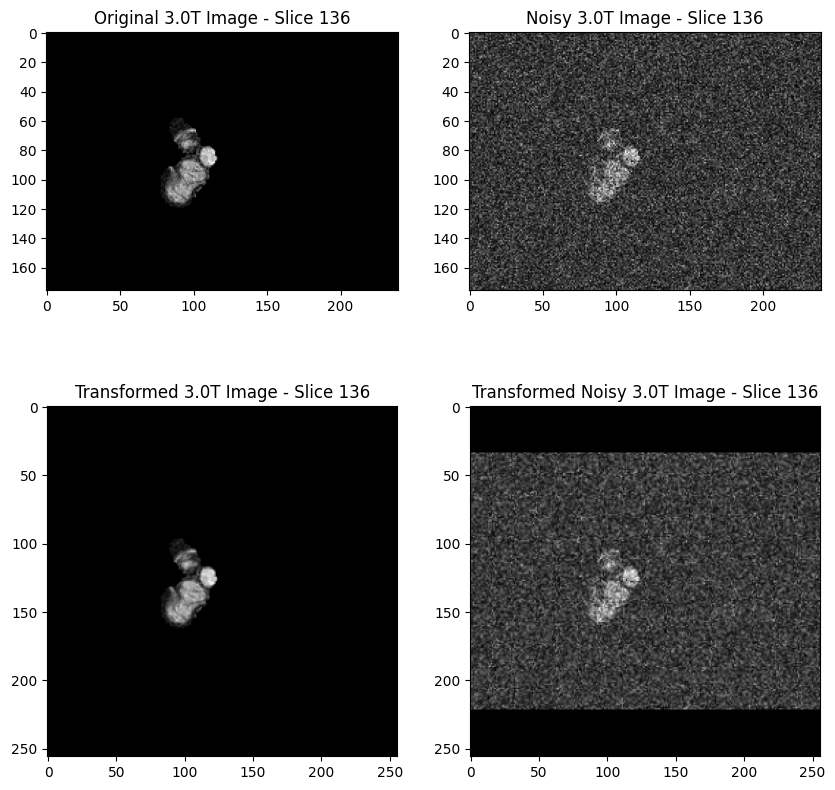

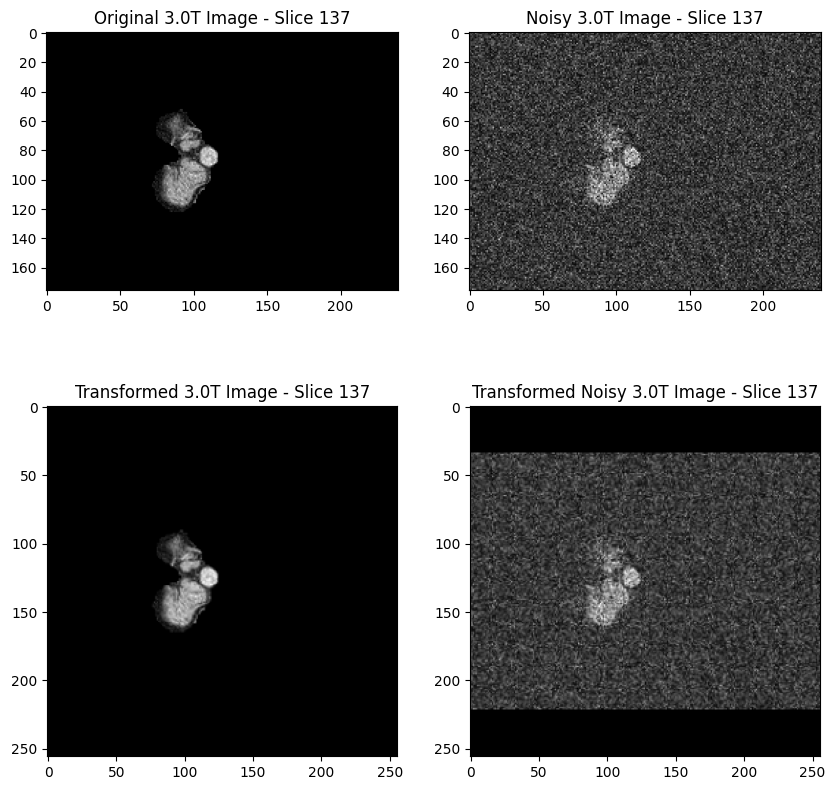

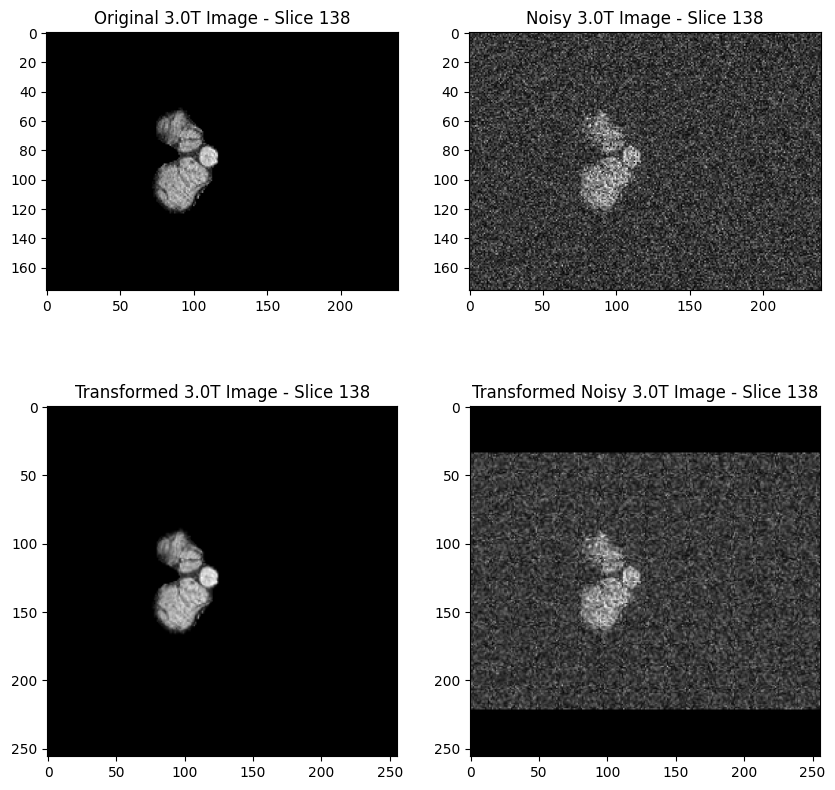

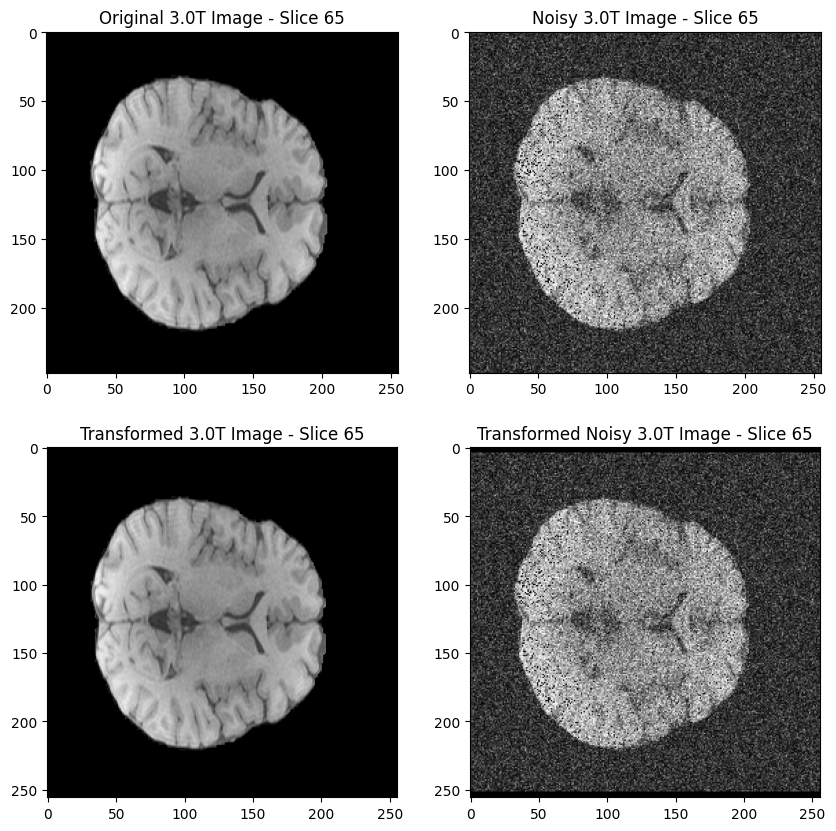

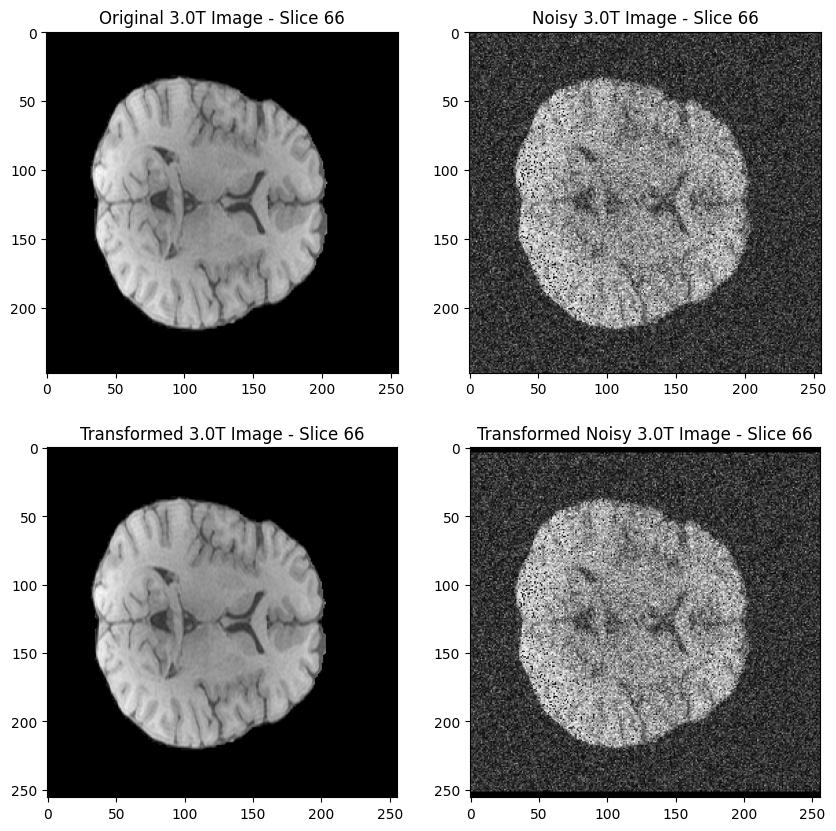

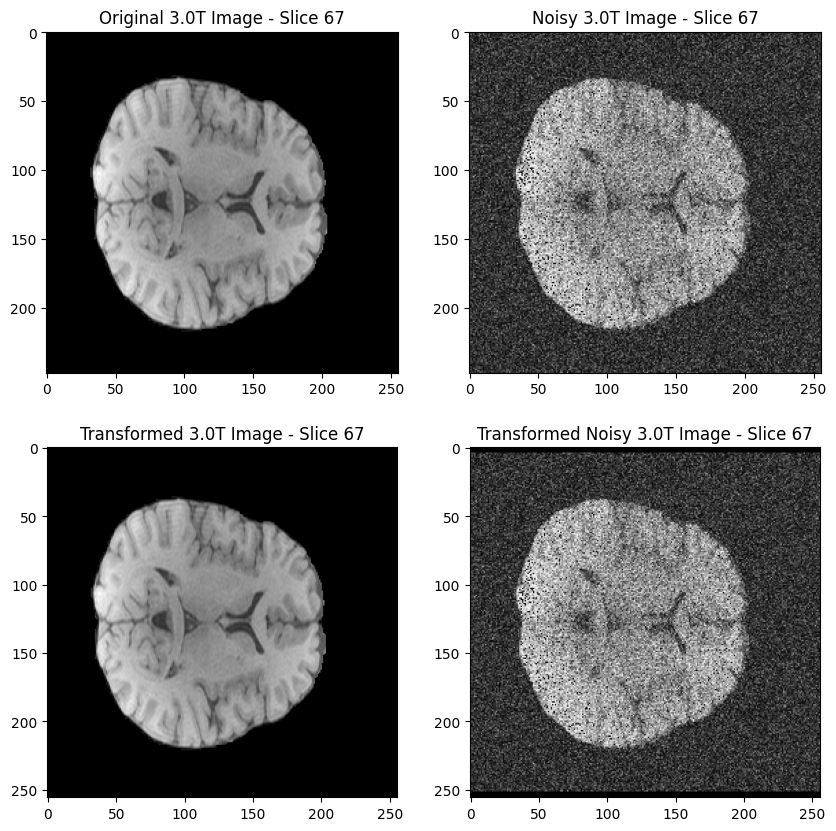

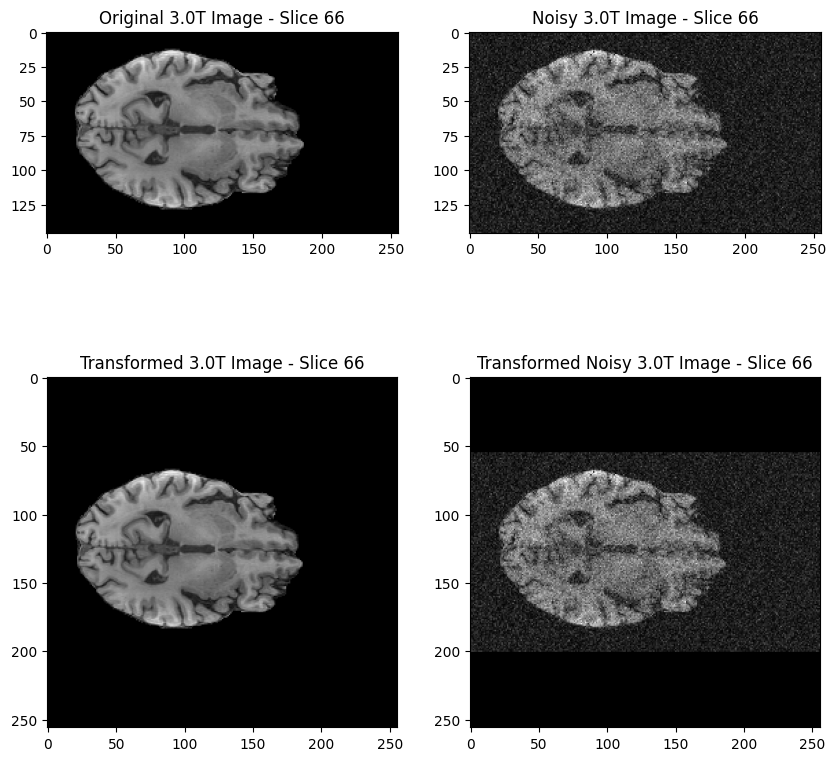

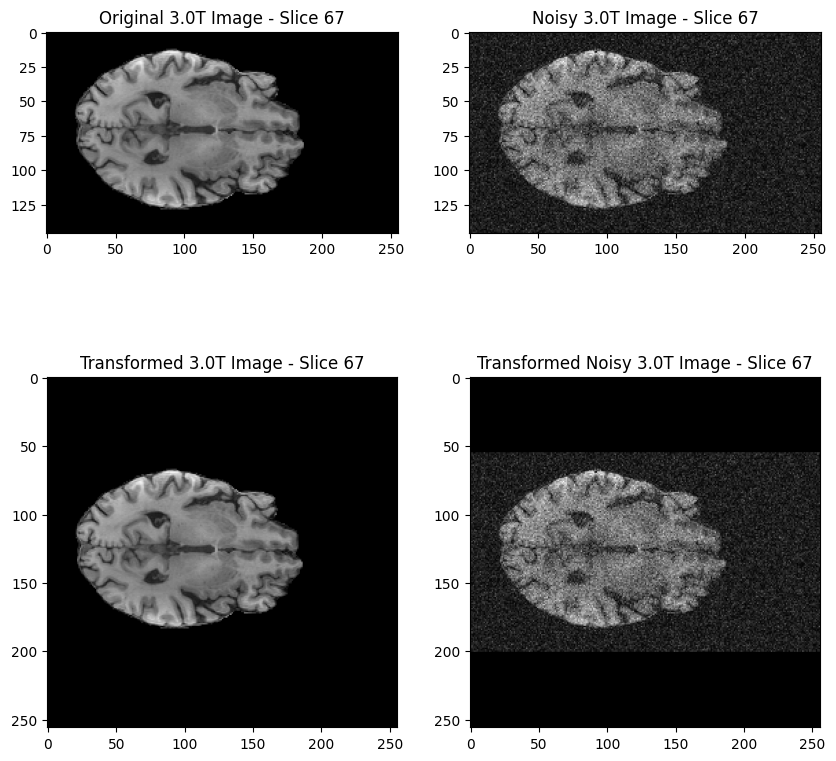

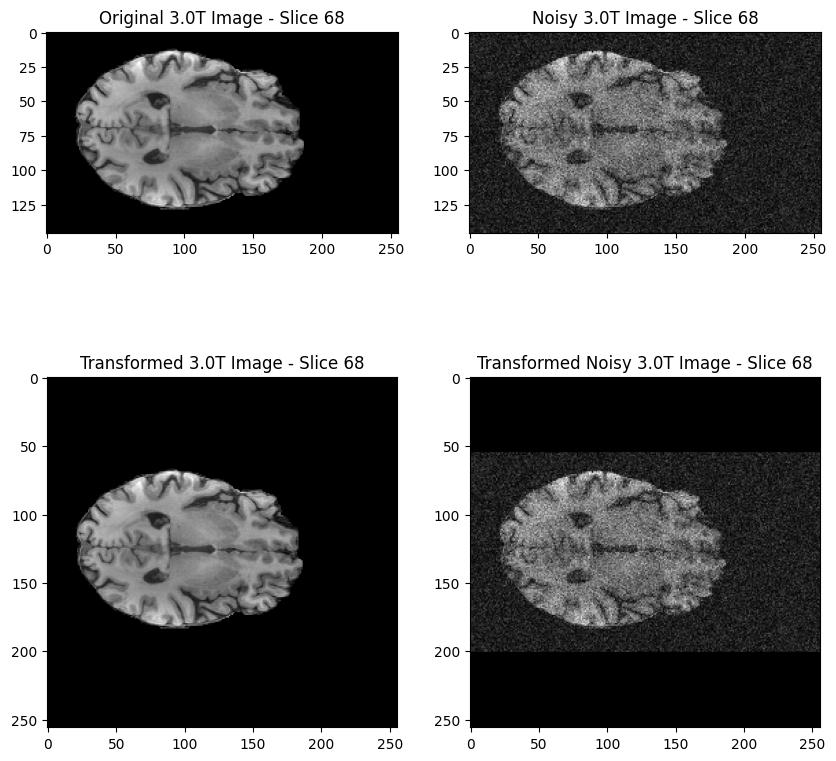

In [6]:
transforms = mn.transforms.Compose([
    mn.transforms.ResizeD(keys=['img', 'concat'], size_mode="longest", mode="bilinear", spatial_size=256, align_corners=False),
    mn.transforms.ScaleIntensityD(keys=['img', 'concat'], minv=-1, maxv=1),
    mn.transforms.SpatialPadD(keys=['img', 'concat'], spatial_size=(256, 256),  mode="constant", constant_values=-1),
    mn.transforms.ToTensorD(keys=['img', 'concat'], dtype=torch.float, track_meta=False),
])

dataset_dir = "/scratch/Costanza/PPMI_SkullStripping"
patient_data_dicts = load_patient_data_only_3T(dataset_dir)

visualize_transformed_images(patient_data_dicts, transforms, num_images=3)

With Augmentation

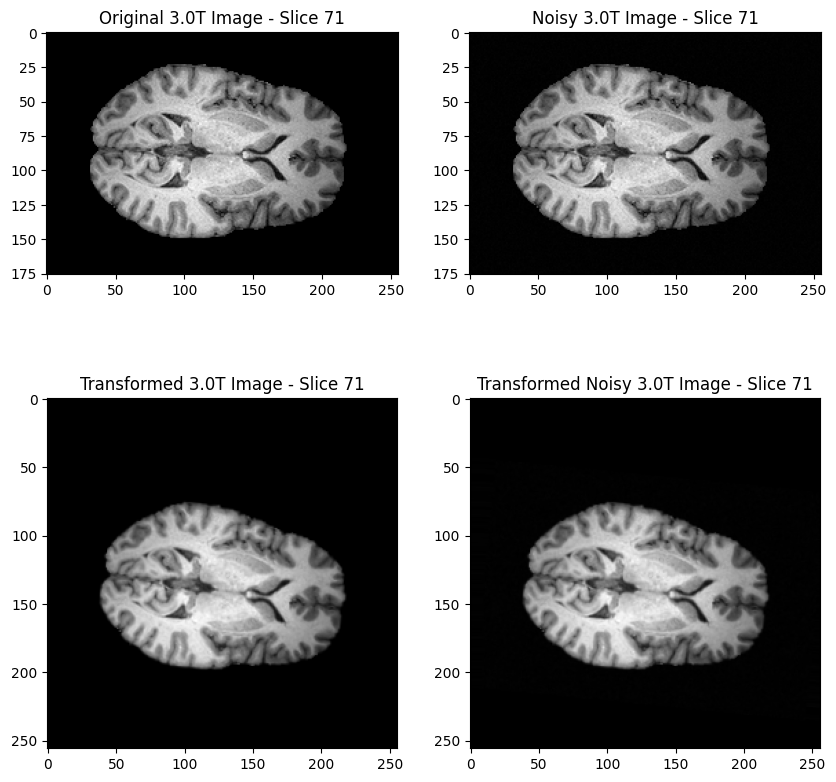

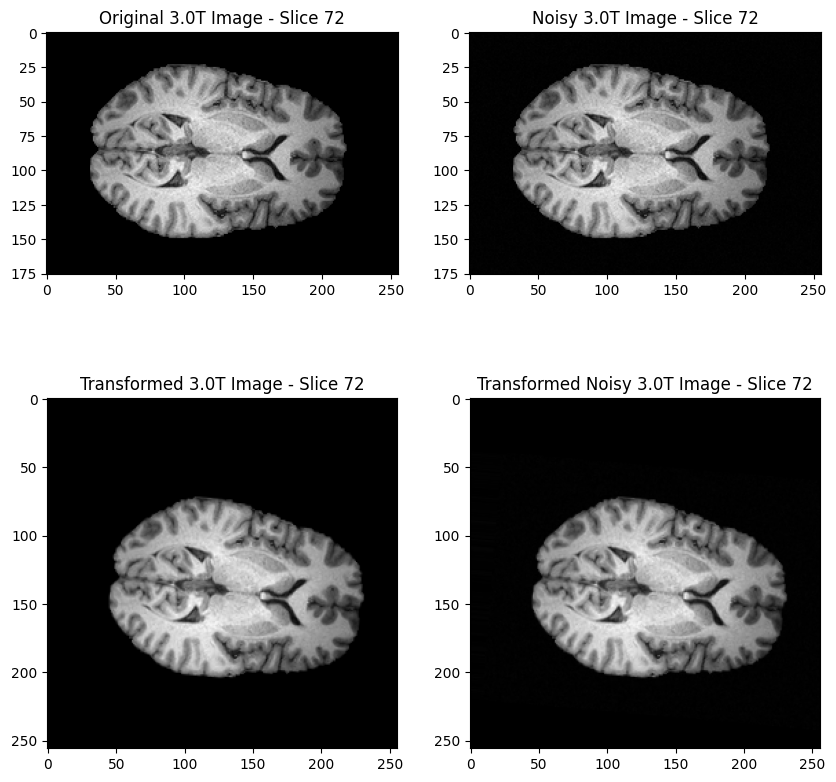

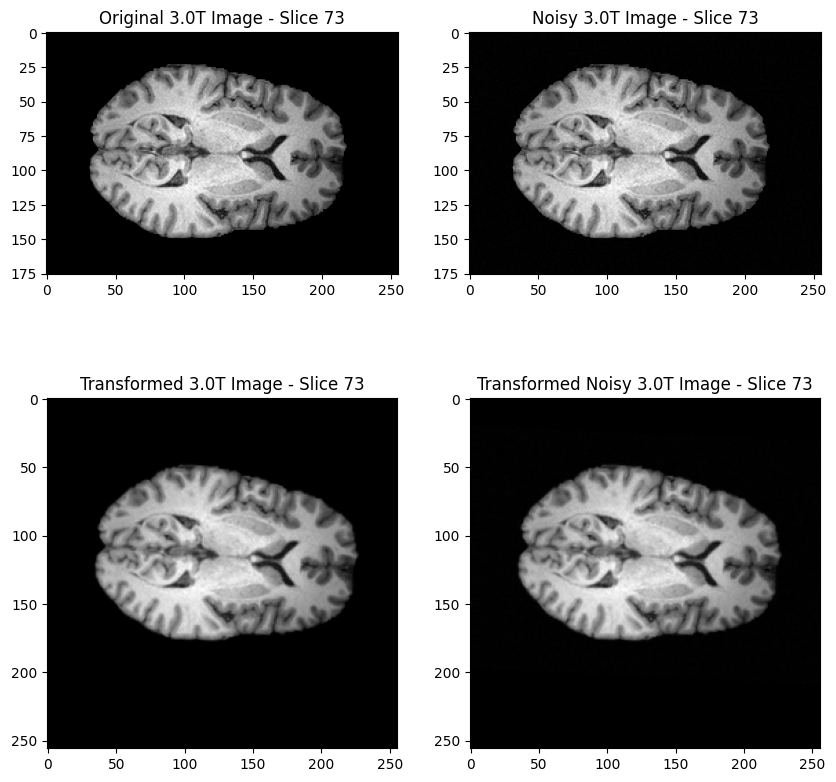

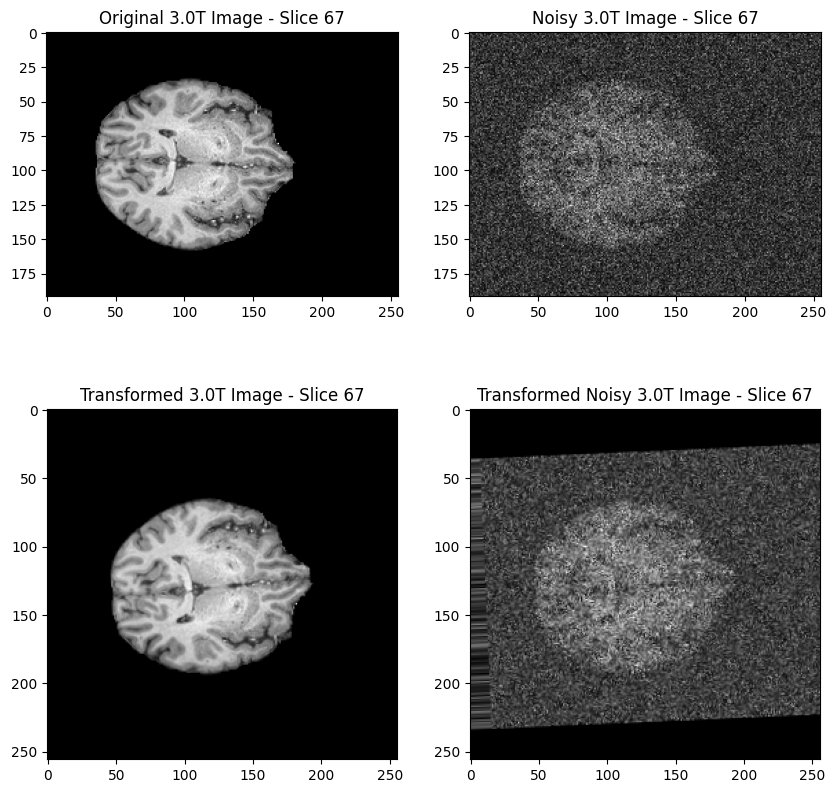

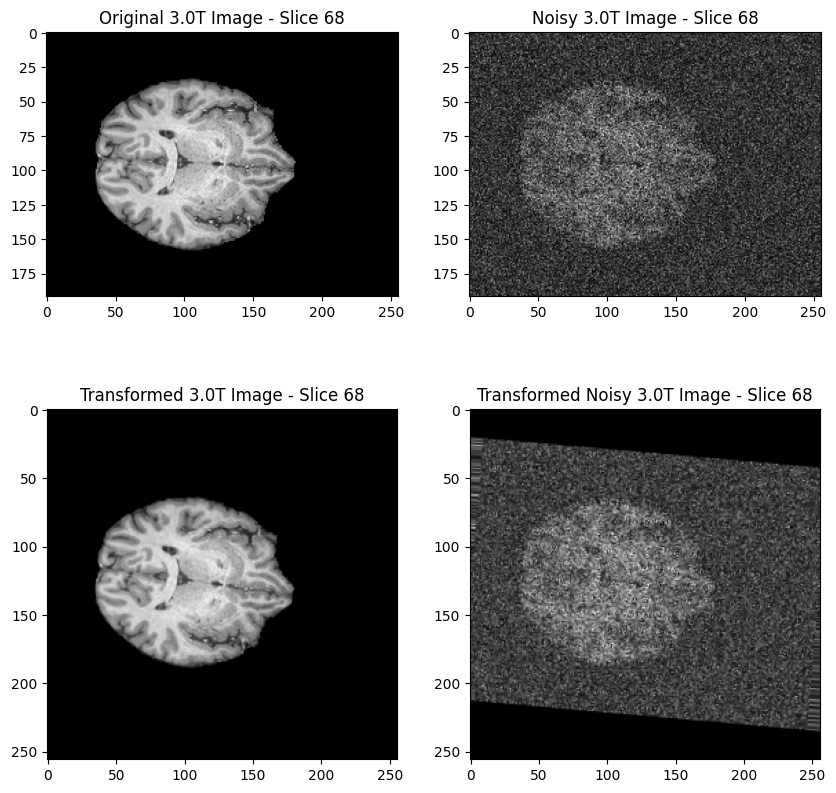

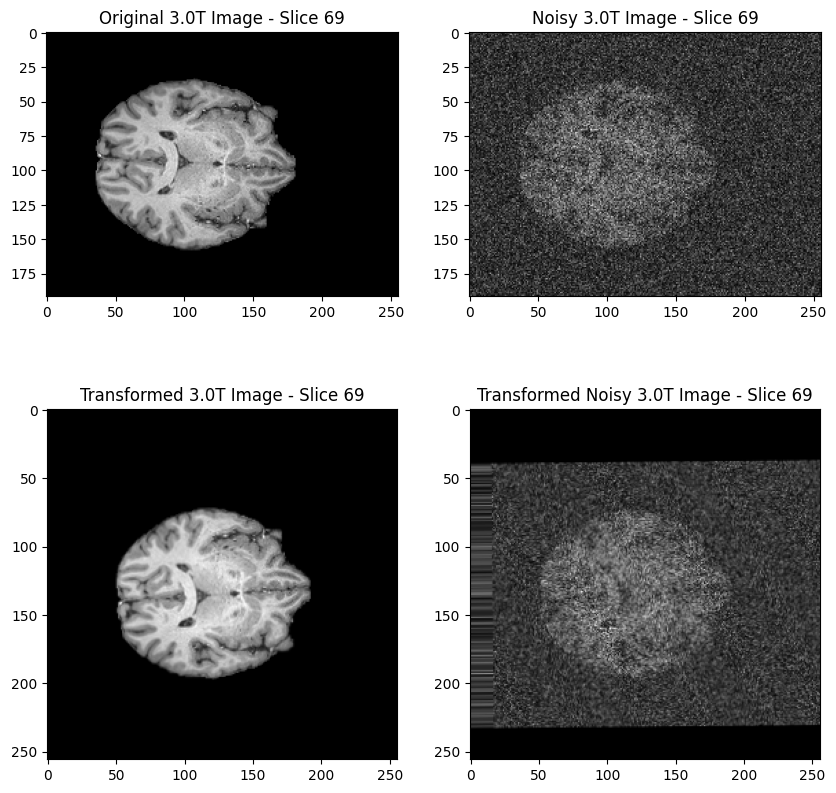

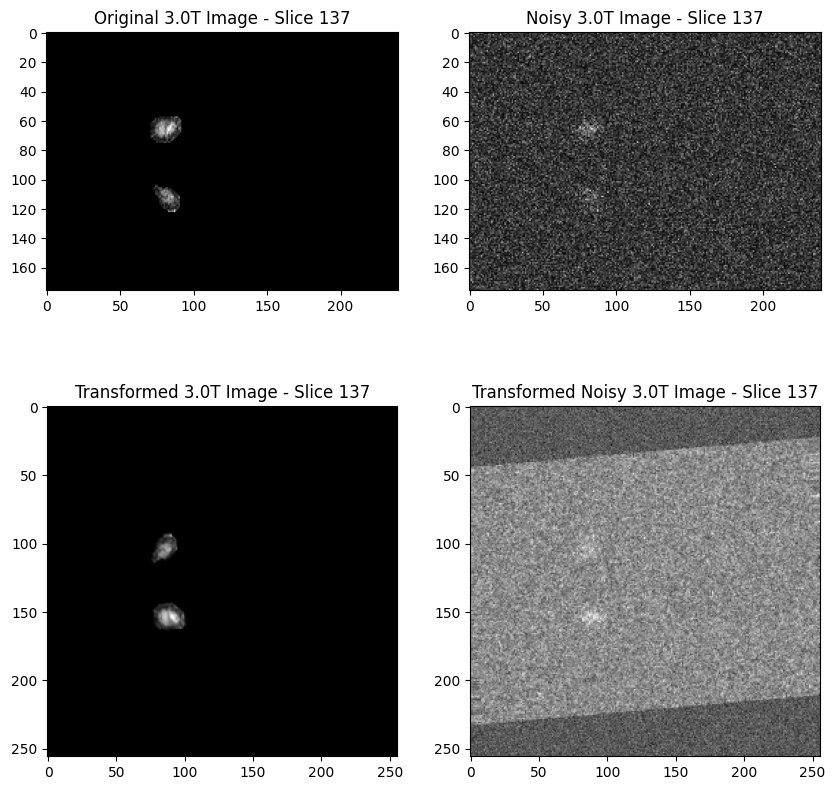

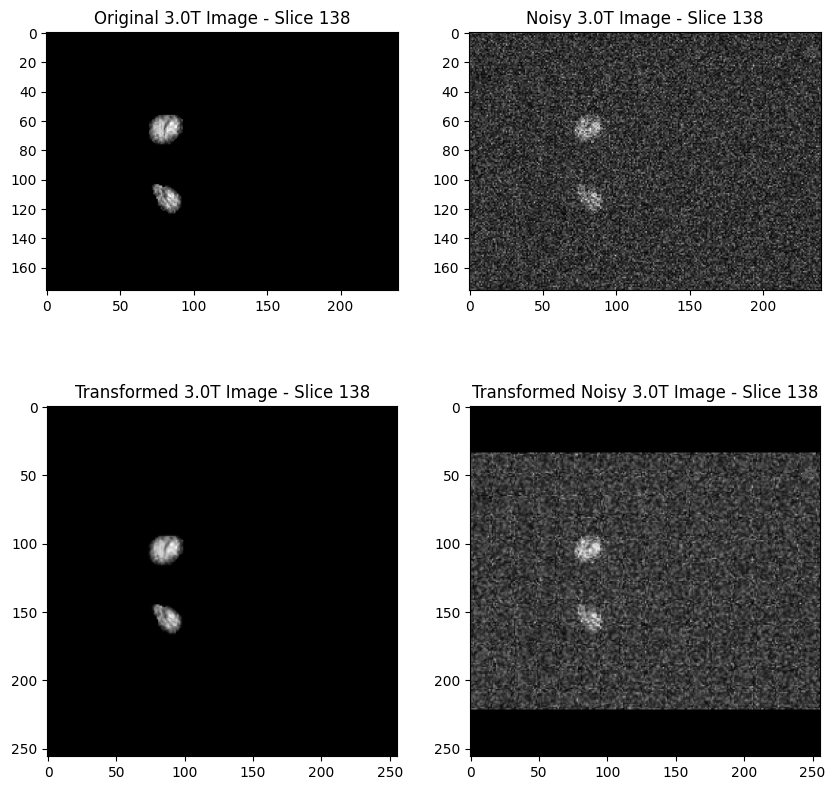

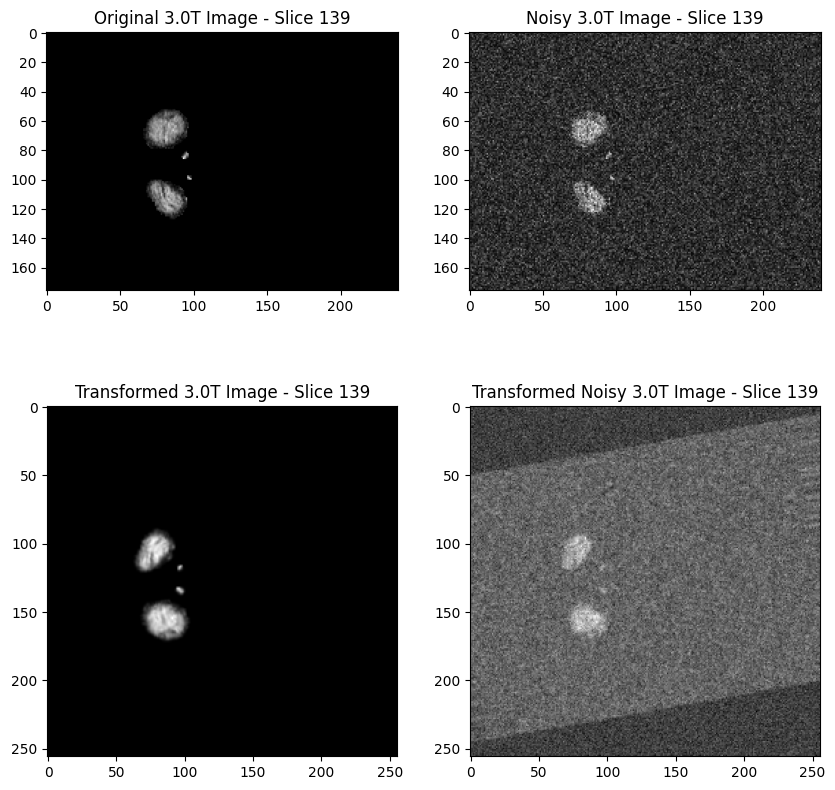

In [7]:
transforms = mn.transforms.Compose([
    mn.transforms.ResizeD(keys=['img', 'concat'], size_mode="longest", mode="bilinear", spatial_size=256, align_corners=False),
    mn.transforms.ScaleIntensityD(keys=['img', 'concat'], minv=-1, maxv=1),
    mn.transforms.SpatialPadD(keys=['img', 'concat'], spatial_size=(256, 256), mode="constant", constant_values=-1),
    # Augmentations:
    mn.transforms.RandRotateD(keys=['img', 'concat'], range_x=(math.radians(5), math.radians(5)), prob=0.5, keep_size=True, mode='bilinear'), # (range +5, -5) degrees
    mn.transforms.RandFlipD(keys=['img', 'concat'], prob=0.5, spatial_axis=0),  # Flip along left-right axis
    mn.transforms.RandAffined(keys=['img', 'concat'], 
                              translate_range=(15, 15), 
                              scale_range=(0.05, 0.05), 
                              rotate_range=(math.radians(5), math.radians(5)), 
                              padding_mode='border', 
                              prob=0.5,
                              mode='bilinear'),
    # Apply Gaussian Noise only to the 1.5T image (concat)
    mn.transforms.RandGaussianNoised(keys=['concat'], prob=0.5, mean=0.0, std=0.2),
    mn.transforms.ToTensorD(keys=['img', 'concat'], dtype=torch.float, track_meta=False),
])


dataset_dir = "/scratch/Costanza/PPMI_SkullStripping"
patient_data_dicts = load_patient_data_only_3T(dataset_dir)

visualize_transformed_images(patient_data_dicts, transforms, num_images=3)